In [1]:
import sys
sys.path.append("../acoustooptic_lab")
from analysis import System
import numpy as np
import matplotlib.pyplot as plt
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def find_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [2]:
laser = System("deflectometry", ["../data/20250331/deflectometry_poc/iter_" + str(x) + ".tdms" for x in range(0, 50)], channel = "Y", set_data = True)

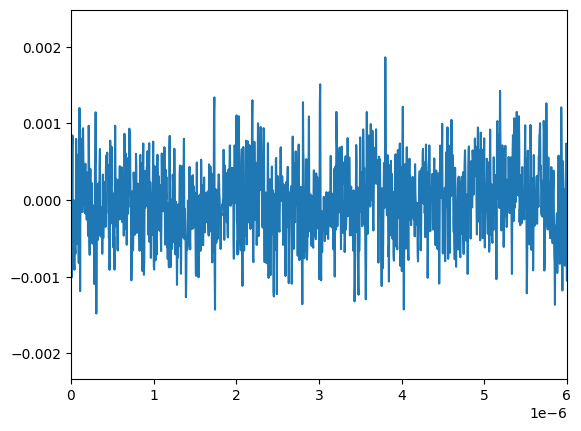

In [11]:
agg = [np.array([laser.get_data()[0].collection[0].t]), np.array([laser.get_data()[0].collection[0].x])]
count = 1
for i, d in enumerate(laser.get_data()):
    d.apply("detrend", mode = "linear", inplace = True)
    for j, c in enumerate(d.collection):
        if i == 0 and j == 0:
            pass
        else:
            agg[0] = np.vstack((agg[0], c.t))
            agg[1] = np.vstack((agg[1], c.x))
            count += 1
agg[0] = np.average(agg[0], axis = 0)
agg[1] = np.average(agg[1], axis = 0)
plt.plot(agg[0], agg[1])
plt.xlim(0.0000, 0.000006)
plt.show()

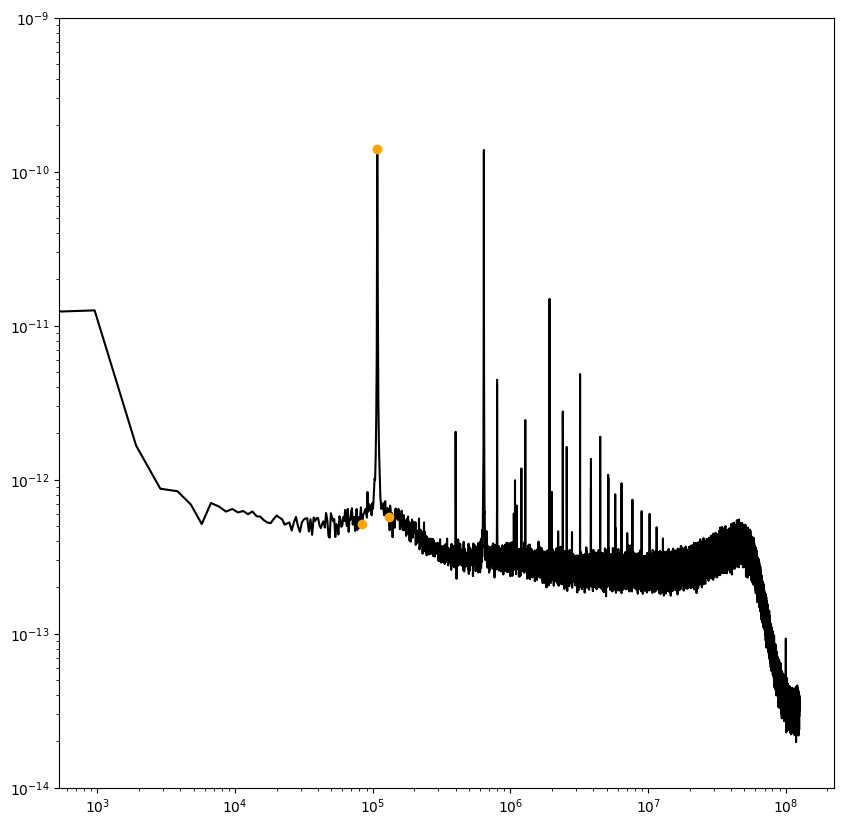

In [4]:
from scipy.signal import periodogram

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
laser.set_data(ind = 0)
laser.get_data()[0].apply("detrend", mode = "linear", inplace = True)
freqs = np.array([periodogram(laser.get_data()[0].collection[0].x, laser.get_data()[0].r, nfft = 2 ** 18)[0]])
psds = np.array([periodogram(laser.get_data()[0].collection[0].x, laser.get_data()[0].r, nfft = 2 ** 18)[1]])
# ax.plot(freqs[0], psds[0])

f, p = periodogram(laser.get_data()[0].collection[1].x, laser.get_data()[0].r, nfft = 2 ** 18)
freqs = np.vstack((freqs, f))
psds = np.vstack((psds, p))
# ax.plot(freqs[1], psds[1])


for i in range(1, len(laser.get_data())):
    laser.set_data(ind = i)
    laser.get_data()[i].apply("detrend", mode = "linear", inplace = True)
    f, p = periodogram(laser.get_data()[i].collection[0].x, laser.get_data()[i].r, nfft = 2 ** 18)
    freqs = np.vstack((freqs, f))
    psds = np.vstack((psds, p))
    # ax.plot(f, p)
    f, p = periodogram(laser.get_data()[i].collection[1].x, laser.get_data()[i].r, nfft = 2 ** 18)
    freqs = np.vstack((freqs, f))
    psds = np.vstack((psds, p))
    # ax.plot(f, p)
f_avg = np.average(freqs, axis = 0)
p_avg = np.average(psds, axis = 0)
ax.plot(f_avg, p_avg, c = "black")

sides = 25 # points
ax.scatter(f_avg[find_idx(p_avg, np.max(p_avg))], p_avg[find_idx(p_avg, np.max(p_avg))], c = "orange", zorder = 1000)
ax.scatter(f_avg[find_idx(p_avg, np.max(p_avg)) - sides], p_avg[find_idx(p_avg, np.max(p_avg)) - sides], c = "orange", zorder = 1000)
ax.scatter(f_avg[find_idx(p_avg, np.max(p_avg)) + sides], p_avg[find_idx(p_avg, np.max(p_avg)) + sides], c = "orange", zorder = 1000)

# ax.set_xlim(0, 2e5)
ax.set_ylim(1e-14, 1e-9)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [ ]:
signal = p_avg[find_idx(p_avg, np.max(p_avg))]
noise = np.append(p_avg[:find_idx(p_avg, np.max(p_avg)) - sides], p_avg[find_idx(p_avg, np.max(p_avg)) + sides:])
noise = np.std(noise)
snr = signal / noise
print(20 * np.log10(snr))
signal = np.mean(p_avg[find_idx(p_avg, np.max(p_avg)) - sides:find_idx(p_avg, np.max(p_avg)) + sides])
noise = np.append(p_avg[:find_idx(p_avg, np.max(p_avg)) - sides], p_avg[find_idx(p_avg, np.max(p_avg)) + sides:])
noise = np.mean(noise)
snr = signal / noise
print(20 * np.log10(snr))
signal = 0
n1 = 0
n2 = 0
for x in range(find_idx(p_avg, np.max(p_avg)) - sides, find_idx(p_avg, np.max(p_avg)) + sides):
    signal += p_avg[x] * f_avg[x]
for x in range(find_idx(p_avg, np.max(p_avg)) - sides - int((sides + 1) / 2), find_idx(p_avg, np.max(p_avg)) - sides):
    n1 += p_avg[x] * f_avg[x]
# print("n1", n1)
n1 *= (f_avg[find_idx(p_avg, np.max(p_avg)) + sides] - f_avg[find_idx(p_avg, np.max(p_avg)) - sides]) / (f_avg[find_idx(p_avg, np.max(p_avg)) - sides] - f_avg[find_idx(p_avg, np.max(p_avg)) - sides - int((sides + 1) / 2)])
# print("normalizer", (f_avg[find_idx(p_avg, np.max(p_avg)) - sides] - f_avg[find_idx(p_avg, np.max(p_avg)) + sides]), (f_avg[find_idx(p_avg, np.max(p_avg)) - sides] - f_avg[find_idx(p_avg, np.max(p_avg)) - sides - int((sides + 1) / 2)]))
for x in range(find_idx(p_avg, np.max(p_avg)) + sides, find_idx(p_avg, np.max(p_avg)) + sides + int(sides / 2)):
    n2 += p_avg[x] * f_avg[x]
# print("n2", n2)
n2 *= (f_avg[find_idx(p_avg, np.max(p_avg)) + sides] - f_avg[find_idx(p_avg, np.max(p_avg)) - sides]) / (f_avg[find_idx(p_avg, np.max(p_avg)) + sides + int(sides / 2)] - f_avg[find_idx(p_avg, np.max(p_avg)) + sides])
# print("normalizer", (f_avg[find_idx(p_avg, np.max(p_avg)) - sides] - f_avg[find_idx(p_avg, np.max(p_avg)) + sides]), (f_avg[find_idx(p_avg, np.max(p_avg)) + sides + int(sides / 2)] - f_avg[find_idx(p_avg, np.max(p_avg)) + sides]))
noise = n1 + n2
snr = signal / noise
print(20 * np.log10(snr))

In [61]:
def signaltonoise(a, axis=0, ddof=0):
    """
    The signal-to-noise ratio of the input data.

    Returns the signal-to-noise ratio of `a`, here defined as the mean
    divided by the standard deviation.

    Parameters
    ----------
    a : array_like
        An array_like object containing the sample data.
    axis : int or None, optional
        If axis is equal to None, the array is first ravel'd. If axis is an
        integer, this is the axis over which to operate. Default is 0.
    ddof : int, optional
        Degrees of freedom correction for standard deviation. Default is 0.

    Returns
    -------
    s2n : ndarray
        The mean to standard deviation ratio(s) along `axis`, or 0 where the
        standard deviation is 0.

    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)
signaltonoise(agg[1])

array(-1.16913269e-17)

TypeError: cannot unpack non-iterable NoneType object

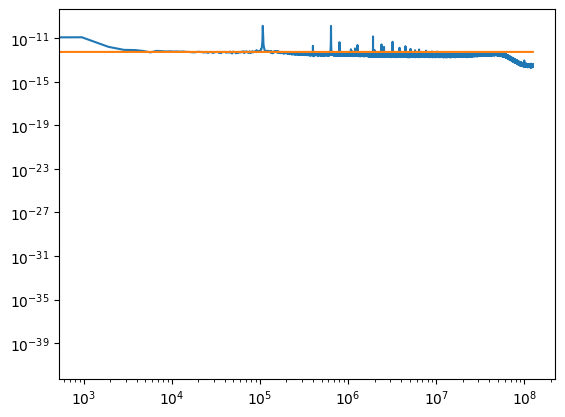

In [5]:
def find_10per(a, s = 25):
    mx = find_idx(a, np.max(a))
    if mx > s:
        idx1 = mx - find_idx(a[mx - s:mx], find_nearest(a[mx - s:mx], np.max(a) * 0.01))
    else:
        idx1 = 0
    if mx + s < len(a) - 1:
        idx2 = mx + find_idx(a[mx:mx + s], find_nearest(a[mx:mx + s], np.max(a) * 0.01))
    else:
        idx2 = len(a) - 1
    return (idx1, idx2)
def cut_harmonics(a, f, m, s = 25):
    f = np.r_[f[:find_10per(a, s)[0]], f[find_10per(a, s)[1]:]]
    a = np.r_[a[:find_10per(a, s)[0]], a[find_10per(a, s)[1]:]]
    return a, f
# def process(a, f, m, s = 25):
    # temp_a = 
plt.loglog(f_avg, p_avg)
plt.loglog(f_avg, np.full(len(f_avg), np.median(p_avg[:find_idx(p_avg, np.max(p_avg))])))
p, f = cut_harmonics(p_avg, f_avg, np.median(p_avg[:find_idx(p_avg, np.max(p_avg))]))
plt.loglog(f, p)
plt.ylim(1e-14, 1e-9)